In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [10]:
batch_size = 32
img_height = 224
img_width = 224

In [11]:
data_dir='/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [12]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [13]:
for image_batch, labels_batch in train.take(1):
    print("Shape of the image batch:", image_batch.shape)
    print("Shape of the labels batch:", labels_batch.shape)
    break

Shape of the image batch: (32, 224, 224, 3)
Shape of the labels batch: (32,)


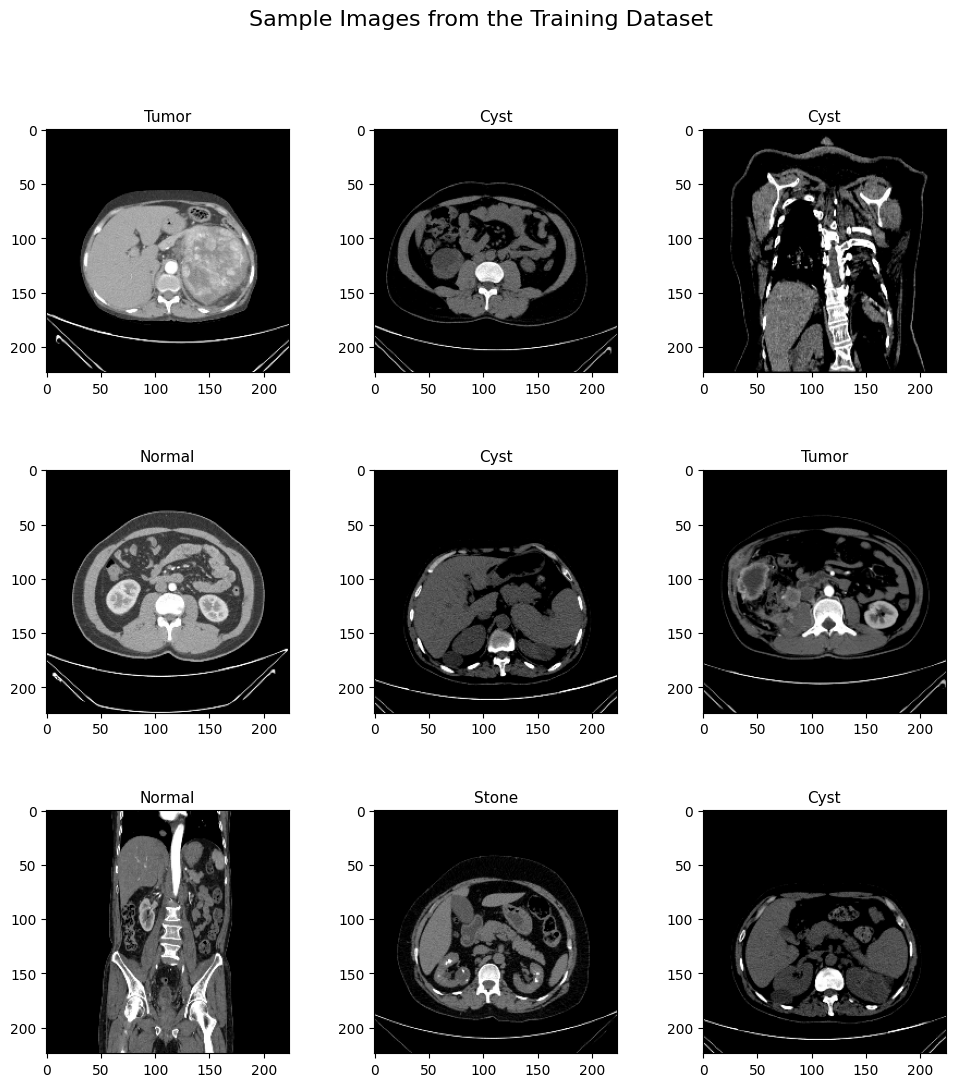

In [14]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        index = i * 3 + j
        image = batch[0][index].astype(int)
        label = label_to_class_name[batch[1][index]]

        # Display the image and set title
        ax[i, j].imshow(image)
        ax[i, j].set_title(label, fontsize=11)

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.suptitle('Sample Images from the Training Dataset', fontsize=16)
plt.show()


In [15]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# MobileNet

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
input_shape = (224, 224, 3)
MobileNetV2_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

for _ in range(8):
    MobileNetV2_model.layers.pop()
for layer in MobileNetV2_model.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(MobileNetV2_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
output = Dense(4, activation='softmax')(x)

mobile_net = Model(inputs=MobileNetV2_model.input, outputs=output)

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 115s 218ms/step - loss: 0.2803 - accuracy: 0.9383 - val_loss: 2.3805 - val_accuracy: 0.6063
Epoch 2/15
351/351 [==============================] - 48s 137ms/step - loss: 0.1393 - accuracy: 0.9816 - val_loss: 14.8060 - val_accuracy: 0.4335
Epoch 3/15
351/351 [==============================] - 47s 134ms/step - loss: 0.1196 - accuracy: 0.9789 - val_loss: 13.4894 - val_accuracy: 0.4544
Epoch 4/15
351/351 [==============================] - 47s 133ms/step - loss: 0.0621 - accuracy: 0.9924 - val_loss: 11.6737 - val_accuracy: 0.4580
Epoch 5/15
351/351 [==============================] - 47s 134ms/step - loss: 0.0395 - accuracy: 0.9959 - val_loss: 11.4792 - val_accuracy: 0.4946
Epoch 6/15
351/351 [==============================] - 47s 134ms/step - loss: 0.0454 - accuracy: 0.9922 - val_loss: 42.6501 - val_accuracy: 0.4022
Epoch 7/15
351/351 [==============================] - 47s 134ms/step - loss: 0.0372 - accuracy: 0.9939 - val_loss: 1.5626 - 

In [20]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('MobileNet_KIDNX_training.csv', index=False)
mobile_net.save('KIDNX_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


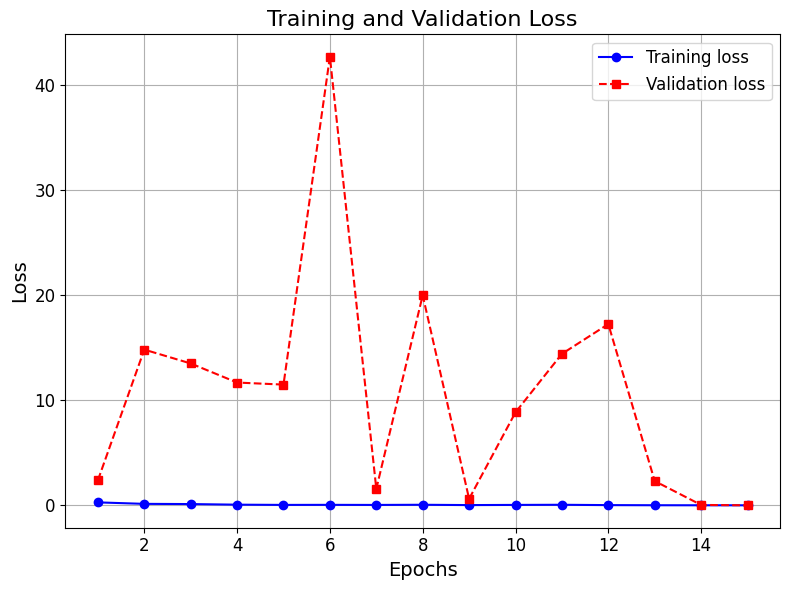

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, label='Training loss', color='blue', marker='o', linestyle='-')
plt.plot(epochs, val_loss, label='Validation loss', color='red', marker='s', linestyle='--')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


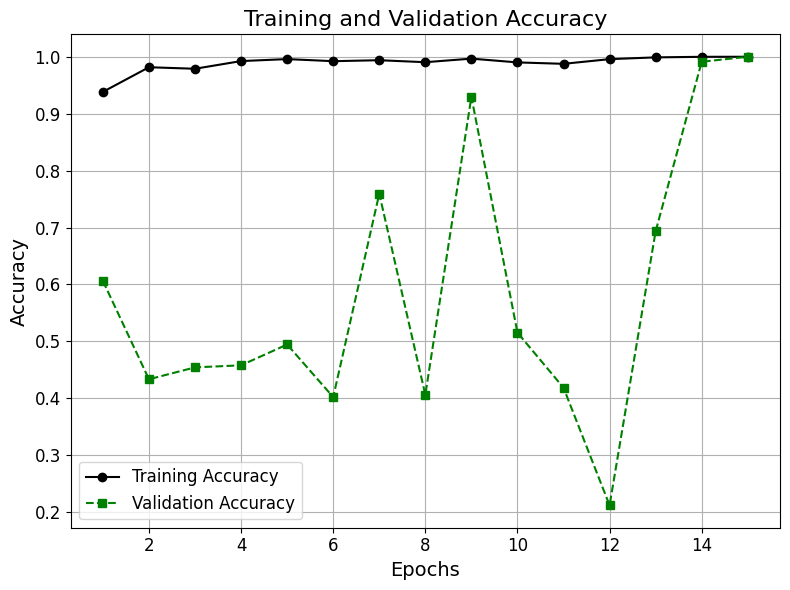

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, label='Training Accuracy', color='black', marker='o', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', marker='s', linestyle='--')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [30]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf


predictions = mobile_net.predict(val)

true_labels = np.concatenate([y for x, y in val], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('MobileNet_confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

78/78 [==============================] - 5s 40ms/step


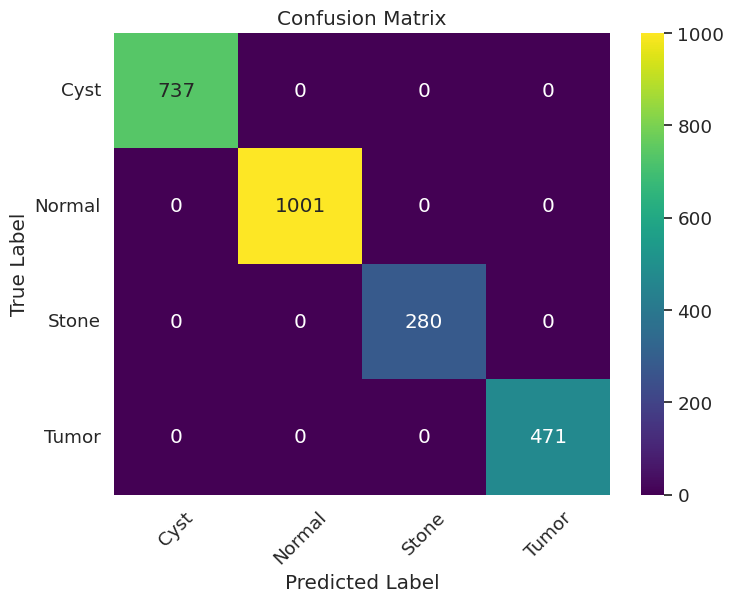

In [31]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

# Load the confusion matrix
with open('MobileNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm_df, annot=True, cmap='viridis', fmt='d', xticklabels=True, yticklabels=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

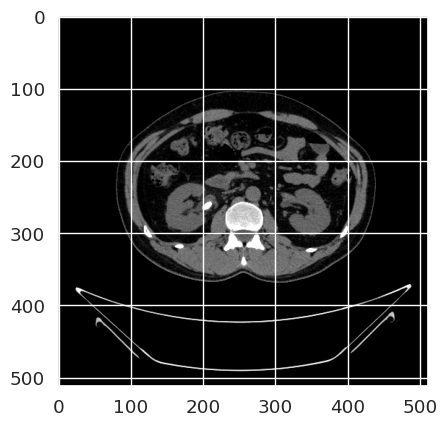

1/1 [==============================] - 0s 55ms/step


'Stone'

In [42]:
img = cv2.imread('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]
